In [2]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

2024-01-10 16:29:52.702477: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
/Users/alitahseen/Desktop/FYP-2024/Machine_learning/venv/lib/python3.9/site-packages/urllib3/__init__.py:34: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


In [3]:
# Load the datasets
train_data = pd.read_csv('/Users/alitahseen/Desktop/FYP-2024/Machine_learning/Datafiles/train1.csv')
test_data = pd.read_csv('/Users/alitahseen/Desktop/FYP-2024/Machine_learning/Datafiles/test1.csv')

# Convert the 'Datetime' column to pandas datetime type
train_data['Datetime'] = pd.to_datetime(train_data['Datetime'])
test_data['Datetime'] = pd.to_datetime(test_data['Datetime'])

# Save Datetime for plotting before dropping it
datetime_test = test_data['Datetime'].copy()


In [4]:
# Convert the 'Datetime' column to pandas datetime type
train_data['Datetime'] = pd.to_datetime(train_data['Datetime'])
test_data['Datetime'] = pd.to_datetime(test_data['Datetime'])

# Extract features from the datetime column (add more if needed)
for df in [train_data, test_data]:
    df['Year'] = df['Datetime'].dt.year
    df['Month'] = df['Datetime'].dt.month
    df['Day'] = df['Datetime'].dt.day
    df['Hour'] = df['Datetime'].dt.hour

# Drop the original datetime column as it's not needed anymore
train_data.drop('Datetime', axis=1, inplace=True)
test_data.drop('Datetime', axis=1, inplace=True)

# Include 'Average_Temp' in the feature set
X_train = train_data[['Year', 'Month', 'Day', 'Hour', 'Average_Temp']]
y_train = train_data['MW']
X_test = test_data[['Year', 'Month', 'Day', 'Hour', 'Average_Temp']]
y_test = test_data['MW']

# Make a copy of the datasets for LEAR and DNN
X_train_lear = X_train.copy()
X_test_lear = X_test.copy()
X_train_dnn = X_train.copy()
X_test_dnn = X_test.copy()

In [5]:
# Linear Regression model
lear_model = LinearRegression()
lear_model.fit(X_train_lear, y_train)


LinearRegression()

In [6]:
# DNN model
dnn_model = Sequential([
    Dense(128, activation='relu', input_shape=(X_train_dnn.shape[1],)),
    Dense(64, activation='relu'),
    Dense(1)
])

dnn_model.compile(optimizer='adam', loss='mean_squared_error')

# Fit the model
dnn_model.fit(X_train_dnn, y_train, epochs=10, batch_size=32)


Epoch 1/10
548/548 [==============================] - 2s 2ms/step - loss: 4559.9932
Epoch 2/10
548/548 [==============================] - 1s 2ms/step - loss: 4062.8894
Epoch 3/10
548/548 [==============================] - 1s 2ms/step - loss: 3829.0532
Epoch 4/10
548/548 [==============================] - 1s 2ms/step - loss: 3712.3555
Epoch 5/10
548/548 [==============================] - 1s 2ms/step - loss: 3588.9905
Epoch 6/10
548/548 [==============================] - 1s 2ms/step - loss: 3608.6929
Epoch 7/10
548/548 [==============================] - 1s 2ms/step - loss: 3505.5442
Epoch 8/10
548/548 [==============================] - 1s 2ms/step - loss: 3454.0349
Epoch 9/10
548/548 [==============================] - 1s 2ms/step - loss: 3467.5576
Epoch 10/10
548/548 [==============================] - 1s 2ms/step - loss: 3421.0933


In [7]:
# Predictions from LEAR
lear_predictions = lear_model.predict(X_test_lear)

# Predictions from DNN
dnn_predictions = dnn_model.predict(X_test_dnn).flatten()


274/274 [==============================] - 0s 1ms/step


In [8]:
# Combine actual and predicted values in a DataFrame
results_comparison = pd.DataFrame({
    'Actual': y_test,
    'LEAR Predictions': lear_predictions,
    'DNN Predictions': dnn_predictions
})


In [9]:
print(results_comparison)

         Actual  LEAR Predictions  DNN Predictions
0     119.51455         72.322280        31.382856
1     114.00266         74.158226        33.935291
2     112.82553         75.979274        36.434330
3     108.65000         77.475578        37.767292
4     107.50238         79.289178        40.233822
...         ...               ...              ...
8755   50.05301        181.761441       140.043793
8756   50.08335        183.442462       142.446625
8757   49.23503        185.008779       144.486877
8758   46.34927        186.476779       146.216339
8759   45.81851        188.157800       148.607819

[8760 rows x 3 columns]


In [10]:
import numpy as np
from sklearn.metrics import mean_absolute_error, mean_squared_error

def calculate_metrics(actual, predicted, threshold=1.0, mape_error_threshold=200):
    mae = mean_absolute_error(actual, predicted)
    rmse = np.sqrt(mean_squared_error(actual, predicted))

    # Filter out pairs where the actual value is above the threshold and percentage error is below the threshold
    valid_indices = (actual > threshold) & (np.abs((predicted - actual) / actual) * 100 < mape_error_threshold)
    filtered_actual = actual[valid_indices]
    filtered_predicted = predicted[valid_indices]

    # Modified MAPE
    if len(filtered_actual) > 0:
        mape = np.mean(np.abs((filtered_actual - filtered_predicted) / filtered_actual)) * 100
    else:
        mape = np.nan  

    # sMAPE
    smape = 100/len(actual) * np.sum(2 * np.abs(predicted - actual) / (np.abs(actual) + np.abs(predicted)))

    return mae, mape, smape, rmse

# Calculate metrics for LEAR and DNN models
lear_metrics = calculate_metrics(y_test, lear_predictions)
dnn_metrics = calculate_metrics(y_test, dnn_predictions)

# Print the metrics
print("LEAR Metrics (MAE, Modified MAPE, sMAPE, rMSE):", lear_metrics)
print("DNN Metrics (MAE, Modified MAPE, sMAPE, rMSE):", dnn_metrics)



LEAR Metrics (MAE, Modified MAPE, sMAPE, rMSE): (76.634000965984, 94.88434944512169, 86.47702010845931, 84.90074359374326)
DNN Metrics (MAE, Modified MAPE, sMAPE, rMSE): (42.40492625678577, 68.3512071280449, 63.46512858419487, 54.67237793348194)


In [11]:
print(y_test)

0       119.51455
1       114.00266
2       112.82553
3       108.65000
4       107.50238
          ...    
8755     50.05301
8756     50.08335
8757     49.23503
8758     46.34927
8759     45.81851
Name: MW, Length: 8760, dtype: float64


In [12]:
print(lear_predictions)

[ 72.32228046  74.15822567  75.97927431 ... 185.00877893 186.47677889
 188.15779978]


  1/274 [..............................] - ETA: 10s

274/274 [==============================] - 0s 1ms/step


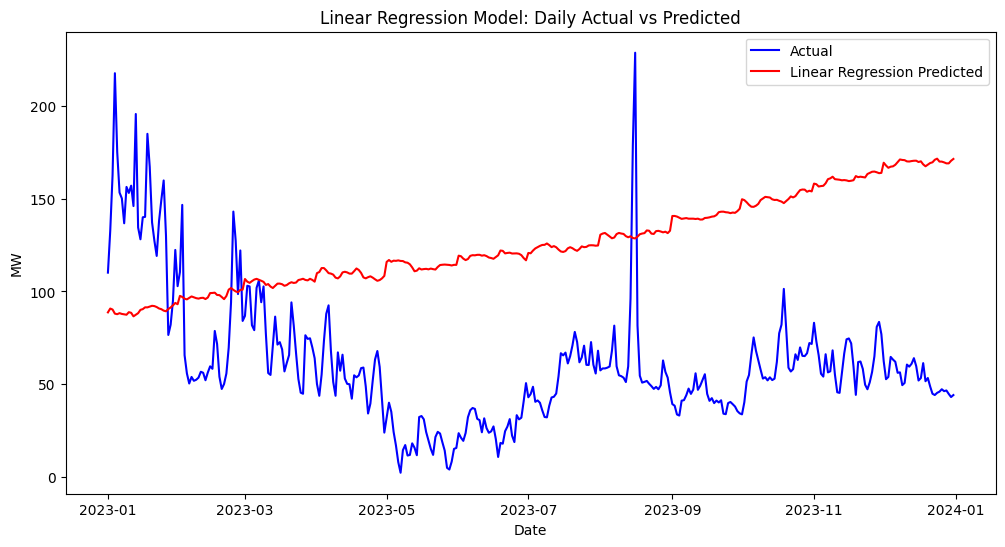

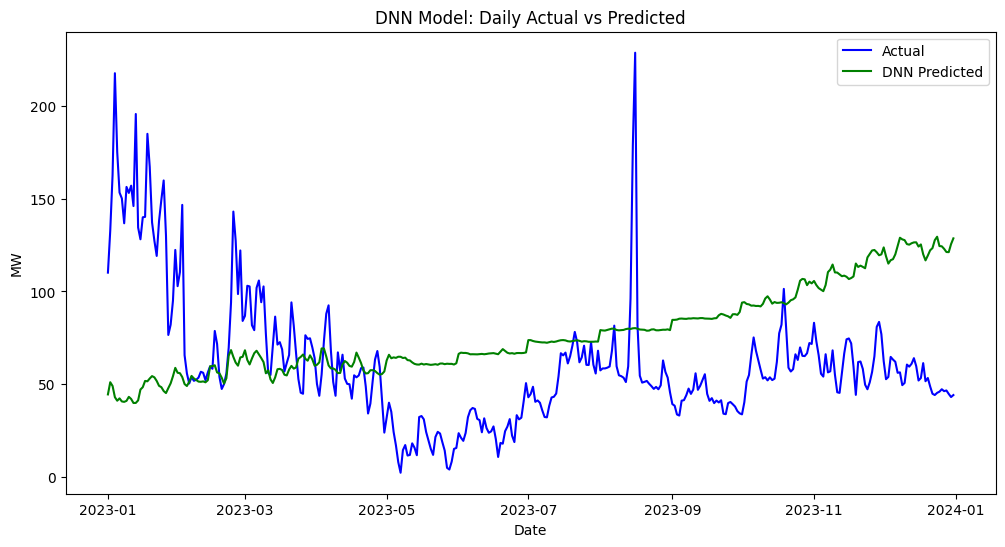

In [13]:
# Predictions from LEAR
lear_predictions = lear_model.predict(X_test)

# Predictions from DNN
dnn_predictions = dnn_model.predict(X_test).flatten()

# Combine datetime, actual, and predicted values in a DataFrame
results_comparison = pd.DataFrame({
    'Datetime': datetime_test,
    'Actual': y_test,
    'LEAR Predictions': lear_predictions,
    'DNN Predictions': dnn_predictions
})

# Convert 'Datetime' to just dates for daily aggregation
results_comparison['Date'] = results_comparison['Datetime'].dt.date

# Group by Date and calculate mean for actual and predicted values
daily_mean = results_comparison.groupby('Date').mean()

# Plotting for LEAR model
plt.figure(figsize=(12, 6))
plt.plot(daily_mean.index, daily_mean['Actual'], label='Actual', color='blue')
plt.plot(daily_mean.index, daily_mean['LEAR Predictions'], label='Linear Regression Predicted', color='red')
plt.title('Linear Regression Model: Daily Actual vs Predicted')
plt.xlabel('Date')
plt.ylabel('MW')
plt.legend()
plt.show()

# Plotting for DNN model
plt.figure(figsize=(12, 6))
plt.plot(daily_mean.index, daily_mean['Actual'], label='Actual', color='blue')
plt.plot(daily_mean.index, daily_mean['DNN Predictions'], label='DNN Predicted', color='green')
plt.title('DNN Model: Daily Actual vs Predicted')
plt.xlabel('Date')
plt.ylabel('MW')
plt.legend()
plt.show()